# First Test: Pytrends

Retrieve information about a search Keyword in a specific location (delimited by a postal code) from Google Trends using Pytrends.



First we install the Pytrends library and import the modules needed.

In [1]:
!pip install pytrends
from pytrends.request import TrendReq
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Google Trends is limited in some countries like Mexico, as it does not provide enough information for individual cities and only state-wide search results. For this reason I am searching for results New York, which returns more information.

In [2]:
pytrend = TrendReq()
# specify the keyword, geo code, and time frame
keyword = ['pizza']
geo = 'US-NY'

# build the payload
pytrend.build_payload(kw_list=keyword, geo=geo)

# retrieve the interest over time data and store it in a DataFrame
interest_df = pytrend.interest_by_region()

# print the DataFrame

interest_df.head(10)

,pizza
geoName,
Albany-Schenectady-Troy NY,95
Binghamton NY,63
Buffalo NY,100
Burlington VT-Plattsburgh NY,69
Elmira NY,74
New York NY,58
Rochester NY,77
Syracuse NY,70
Utica NY,93


As we can see, this script succesfully returns a dataframe for searches for the word 'pizza' in New York. Let's discuss how to interpret these results.

The results Google Trends provides are not an estimate of search volume, but rather relative popularity. The results may range from 0 to 100, with 0 meaning the term is not popular and 100 meaning the term is at its peak popularity for that region (relative to the total volume of all searches). For example, in Rochester NY the result is 76, which would imply the term 'pizza' is among the top 24% results in that city. Based on our dataframe, we can see that Buffalo has the biggest relative interest in pizza, while New York has the lowest. 

Now, it is expected that pizza is a popular search term due to the popularity of the food. Let's now try to search for a more specific term such as 'chiropractor'.

In [3]:
from numpy.lib.arraysetops import intersect1d
pytrend = TrendReq()
# specify the keyword, geo code, and time frame
keyword = ['chiropractor']
geo = 'US-NY'

# build the payload
pytrend.build_payload(kw_list=keyword, geo=geo)

# retrieve the interest over time data and store it in a DataFrame
interest_df = pytrend.interest_by_region()

# print the DataFrame

interest_df.head(10)





,chiropractor
geoName,
Albany-Schenectady-Troy NY,78
Binghamton NY,81
Buffalo NY,100
Burlington VT-Plattsburgh NY,69
Elmira NY,99
New York NY,72
Rochester NY,79
Syracuse NY,71
Utica NY,78


In [4]:
interest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Albany-Schenectady-Troy NY to Watertown NY
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   chiropractor  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0+ bytes


As we can see here, the dataframe pytrends returns only has 1 column, and geoName is an index and not a column in itself. This will create problems when analyzing the locations, for this reason I convert our dataframe to a new one where geoName is a column and not an index so that we can access this parameter further on.

In [5]:
loc_df = interest_df.reset_index(drop=False)

# Print the new DataFrame
print(loc_df)

                        geoName  chiropractor
0    Albany-Schenectady-Troy NY            78
1                 Binghamton NY            81
2                    Buffalo NY           100
3  Burlington VT-Plattsburgh NY            69
4                     Elmira NY            99
5                   New York NY            72
6                  Rochester NY            79
7                   Syracuse NY            71
8                      Utica NY            78
9                  Watertown NY            92


Finally, we will convert this dataframa to a CSV file, this is only if you want to save this file to your computer. If not, you can keep working with just the dataframe.

In [6]:
loc_df.to_csv("locations.csv", index=False)

For our following step, we want to know how many places offer this service in these cities so as to make a correlation between interest and availability of this service. To do this we will make use of Google Maps.

# Places API
To retrieve information on search results on Google Maps we can use the Places API provided by Google Cloud services. For this we only require an API key and a very simple Python script. 
The parameters we will specify are a keyword, a location (New York) and a radius. A smaller radius yields more information when studying a small but densely populated area; I will use a radius of 50 km for the state of New York. 

In [8]:
import requests

# Replace YOUR_API_KEY with your actual API key
API_KEY = 'I_SHOULDNT_SHARE_MY_OWN_KEY'

# Define the search parameters
params = {
    'key': API_KEY,
    'query': 'chiropractor', # replace with your desired keyword
    'location': '40.7484,-73.9857', # latitude and longitude of New York City
    'radius': 10 
}

# Send a GET request to the Places API
response = requests.get('https://maps.googleapis.com/maps/api/place/textsearch/json', params=params)

# Retrieve the number of places returned by the search
results = response.json()
num_places = len(results['results'])

print(f"{num_places} places found for '{params['query']}' in New York, USA")


20 places found for 'chiropractor' in New York, USA


Let's store our results in a dataframe so we can read them easily.

In [ ]:
# Create a Pandas DataFrame to store the search results
places = pd.DataFrame(columns=['name', 'address', 'latitude', 'longitude'])

# Iterate over each place in the search results and extract its details
for place in results['results']:
    name = place['name']
    address = place.get('formatted_address', '')
    location = place['geometry']['location']
    latitude = location.get('lat', None)
    longitude = location.get('lng', None)
    
    # Add the place details to the DataFrame as a new row
    places = places.append({'name': name, 'address': address, 
                            'latitude': latitude, 'longitude': longitude}, 
                           ignore_index=True)

For our next step, we want to perform queries for each location in our locations data frame (locations.csv). We can achieve this with a loop, searching for our keyword 'chiropractor' in each location in our dataframe. However, Places needs latitude and longitude information. Let's first obtain the latititude and longitude of each of our locations and add it to our data frame with the function get_lat_long. Then, we can pass these parameters to Places.

In [10]:
import pandas as pd
import requests
from geopy.geocoders import Nominatim

# Set up the Google Places API search parameters
API_KEY = ''I_SHOULDNT_SHARE_MY_OWN_KEY''
SEARCH_RADIUS = 10
SEARCH_QUERY = 'chiropractor'

# Function to get the latitude and longitude of a location using geopy
def get_lat_long(location):
    # Use geopy to get the latitude and longitude of the given location
    geolocator = Nominatim(user_agent="http")
    location = geolocator.geocode(location)
    if location is not None:
        return (location.latitude, location.longitude)
    else:
        return (None, None)

# Read the dataframe with geoNames and chiropractor columns
df = pd.read_csv('locations.csv')

# Add two new columns to the dataframe for the latitude and longitude values
df['latitude'] = 0.0
df['longitude'] = 0.0

# Loop through each row in the dataframe
for index, row in df.iterrows():
    # Get the latitude and longitude of the current row's geoName using geopy
    location = row['geoName']
    lat, long = get_lat_long(location)
    
    # Update the latitude and longitude values in the dataframe
    df.at[index, 'latitude'] = lat
    df.at[index, 'longitude'] = long
          
    
# Save the updated dataframe to a new CSV file
df.to_csv('updated_dataframe.csv', index=False)


Now I want to use this updated dataframe to do the following:

For each entry in the data frame, I want to get the number of results for the query 'chiropractor' using the Places api, passing the entry's values of latitude and longitude as the location. 
Then, I will create a new dataframa where I will save the location name (geoName) and the number of results it returned. 

In [26]:
import pandas as pd
import requests
import time
def get_num_results(latitude, longitude):
    if latitude is None or longitude is None:
      return None
    # Replace YOUR_API_KEY with your actual API key
    API_KEY = ''I_SHOULDNT_SHARE_MY_OWN_KEY''

    # Define the search parameters
    params = {
        'key': API_KEY,
        'query': 'chiropractic clinic', # replace with your desired keyword
        'location': f'{latitude},{longitude}', # latitude and longitude of the current row
        'radius': 10, # 
        'minrating': 3, # minimum rating score
    }

    
    # Send a GET request to the Places API
    response = requests.get('https://maps.googleapis.com/maps/api/place/nearbysearch/json', params=params)

    # Retrieve the number of places returned by the search
    results = response.json()
    num_places = len(results['results'])

    while 'next_page_token' in results:
        # Sleep for a few seconds to allow the next page to become available
        time.sleep(2)

        # Define the search parameters with the pagetoken parameter to fetch the next page
        params['pagetoken'] = results['next_page_token']

        # Send a GET request to the Places API to fetch the next page of results
        response = requests.get('https://maps.googleapis.com/maps/api/place/nearbysearch/json', params=params)

        # Retrieve the number of places returned by the search
        results = response.json()
        num_places += len(results['results'])


    return num_places


# Read the dataframe with geoNames, chiropractor, latitude, and longitude columns
df = pd.read_csv('updated_dataframe.csv')

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['geoName', 'num_results'])

# Loop through each row in the dataframe and get the number of search results
for index, row in df.iterrows():
    # Get the latitude and longitude of the current row
    latitude = row['latitude']
    longitude = row['longitude']

    # Get the number of search results from the Places API
    num_results = get_num_results(latitude, longitude)    

    # Add the location name and number of search results to the results dataframe
    results_df.loc[index] = [row['geoName'], num_results]



# Print the results dataframe
print(results_df)


                        geoName  num_results
0    Albany-Schenectady-Troy NY            1
1                 Binghamton NY            2
2                    Buffalo NY            2
3  Burlington VT-Plattsburgh NY            0
4                     Elmira NY           23
5                   New York NY           60
6                  Rochester NY            3
7                   Syracuse NY           60
8                      Utica NY           26
9                  Watertown NY           35


Note: Using time = 3 and time = 10 yields same results

As I mentioned before, Google Trends returns relative numbers, not the exact number of searches. In order to compare Trends and Places, let's also convert our dataframe to percentages: our highest result will be 100 and the rest will be relative to that.

In [30]:
import pandas as pd

# Find the maximum value of "num_results"
max_num_results = results_df['num_results'].max()

# Calculate the percentages
results_df['percentage'] = (results_df['num_results'] / max_num_results) * 100

# Print the updated dataframe with the calculated percentages
print(results_df)


                        geoName  num_results  percentage
0    Albany-Schenectady-Troy NY            1    1.666667
1                 Binghamton NY            2    3.333333
2                    Buffalo NY            2    3.333333
3  Burlington VT-Plattsburgh NY            0    0.000000
4                     Elmira NY           23   38.333333
5                   New York NY           60  100.000000
6                  Rochester NY            3    5.000000
7                   Syracuse NY           60  100.000000
8                      Utica NY           26   43.333333
9                  Watertown NY           35   58.333333


In [31]:
#Export csv
results_df.to_csv('location results.csv',index=False)

To be able to compare the results we will create a heat map. To do this, first we will add the num_results column to our location dataframe. Then we need to create a parameter to be able to determine whether the service is being satisfied or not.
We will divide the number of results por places (num_places) and the number of search results for the keyword 

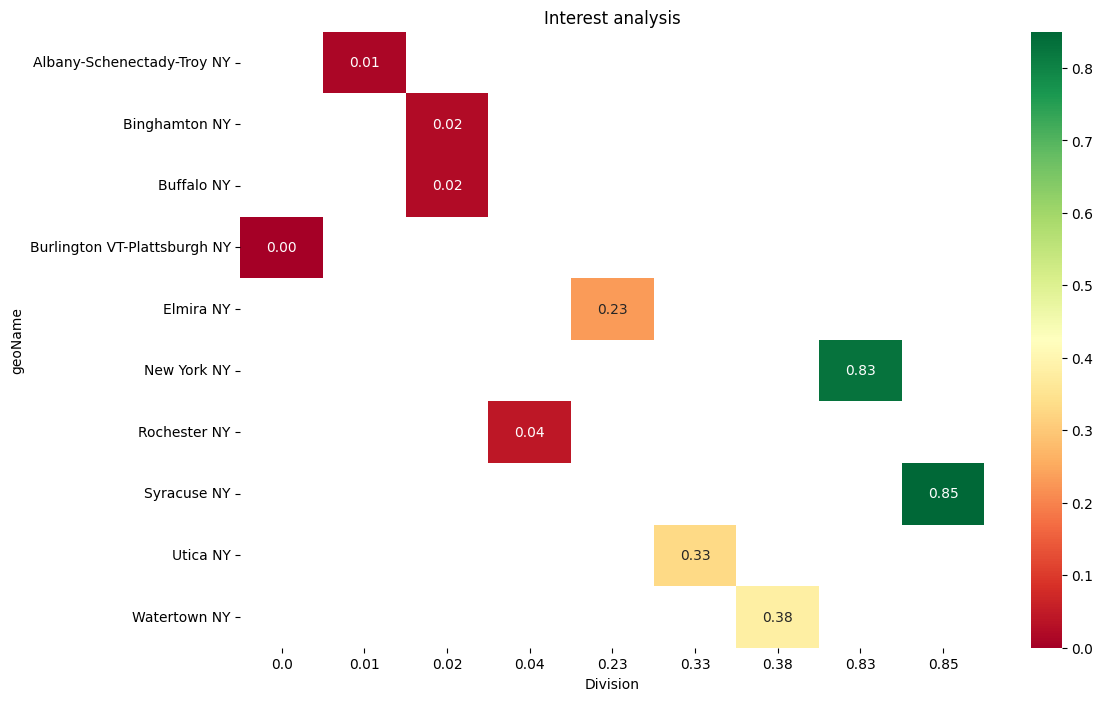

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the first CSV file
df1 = pd.read_csv('locations.csv')

# Read the second CSV file
df2 = pd.read_csv('location results.csv')

# Merge the 'num_results' column from df2 into df1 based on 'geoName'
merged_df = df1.merge(df2[['geoName', 'num_results']], on='geoName')


# Replace zero values in 'num_results' with a small value to avoid errors. 
merged_df['num_results'] = merged_df['num_results'].replace(0, 0.00001)

# Calculate the division between 'chiropractor' and 'num_results'
merged_df['division'] = (merged_df['num_results'] / merged_df['chiropractor']).round(2)

# Create a heat map using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.pivot(index='geoName', columns='division', values='division'),
            cmap='RdYlGn', vmin=0, vmax=merged_df['division'].max(), annot=True, fmt='.2f')
plt.title('Relation between interest and availability for Chiropractors')
plt.xlabel('Division')
plt.ylabel('geoName')
plt.show()



This is our final result. A red box indicates that there are less locations than interest, while a green box indicates that the relation between interest and availability is closer to 1:1. 


**How can I use this?**

A clear example would be, 'where should I open a new branch for my bussiness? It would be more convenient to open a branch where there is interest, but not enough availability - for instance in Albany. This graph shows that there is interest for chiropractors, but little establishments so satisfy this need. 

Another example: It would not be convenient to open a branch in Syracyse, NY because this service is relatively satisfied. 